<a href="https://colab.research.google.com/github/basselkassem/predict_income_potential/blob/master/model_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = "/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/data/"
model_path = '/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/models/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install catboost

     |████████████████████████████████| 62.9MB 38.9MB/s 


# Import Libs

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Load data

In [0]:
data = pd.read_pickle(data_path + 'data_cont_cat_lb.pkl')
features = list(np.load(data_path + 'features.pkl.npy'))
print('data shape: ', data.shape)
print('features lenght: ', len(features))

data shape:  (48813, 39)
features lenght:  31


# Model definition

## Hyperparameter Tuning

In [0]:
data = data[features + ['target']]
X, y = data.drop(columns = 'target'), data['target']

In [0]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from catboost import Pool, cv
def objective(params):
  local_params = {
      'iterations': 4000,
      'od_type': 'Iter',
      'od_wait': 50,
      'loss_function': 'Logloss',
      'verbose': False,

      'learning_rate': float('{:.3f}'.format(params['learning_rate'])),
      'depth': int(params['depth']),
      'l2_leaf_reg': int(params['l2_leaf_reg']),
      'bagging_temperature': float('{:.3f}'.format(params['bagging_temperature'])),
      'one_hot_max_size': int(params['one_hot_max_size']),
  }
  cv_dataset = Pool(data = X, label = y,)
  cv_results = cv(
      cv_dataset,
      local_params,
      fold_count = 5, 
      plot = 'True',
  )
  print('Best num_boost_round: {}'.format(cv_results.tail(1)['iterations'].values[0]))
  print("Best CV score {:.3f} params {}".format(cv_results.tail(1)['test-Logloss-mean'].values[0], local_params))
  return cv_results.tail(1)['test-Logloss-mean'].values[0]

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),    
    'depth': hp.quniform('depth', 4, 10, 1),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 100, 1),
    'bagging_temperature': hp.quniform('bagging_temperature', 0, 10, 1),
    'one_hot_max_size': hp.quniform('one_hot_max_size', 2, 300, 1),
}

best = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 100)

In [0]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'bagging_temperature': 7.0, 'depth': 4.0, 'l2_leaf_reg': 1.0, 'learning_rate': 0.049782825282973404, 'one_hot_max_size': 39.0}


# Model trainig

In [0]:
data = data[features + ['target']]
X, y = data.drop(columns = 'target'), data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [0]:
catboost_params = {
  'bagging_temperature': 7.0,
 'depth': 4.0,
 'l2_leaf_reg': 1.0,
 'learning_rate': 0.049782825282973404,
 'one_hot_max_size': 39.0,
}

In [0]:
start = time.time()
model = CatBoostClassifier(
    iterations = 4000,
    od_type = 'Iter',
    od_wait = 50,
    **catboost_params
)
model.fit(
    X_train, y_train,
    eval_set = (X_val, y_val),
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())
print('it took: ', round(time.time() - start), 'seconds')

0:	learn: 0.6465997	test: 0.6466674	best: 0.6466674 (0)	total: 16.9ms	remaining: 1m 7s
1:	learn: 0.6052964	test: 0.6056900	best: 0.6056900 (1)	total: 37.5ms	remaining: 1m 14s
2:	learn: 0.5656437	test: 0.5662346	best: 0.5662346 (2)	total: 58.5ms	remaining: 1m 17s
3:	learn: 0.5312598	test: 0.5318322	best: 0.5318322 (3)	total: 76.5ms	remaining: 1m 16s
4:	learn: 0.5055899	test: 0.5063174	best: 0.5063174 (4)	total: 93.5ms	remaining: 1m 14s
5:	learn: 0.4821870	test: 0.4826761	best: 0.4826761 (5)	total: 112ms	remaining: 1m 14s
6:	learn: 0.4609566	test: 0.4614467	best: 0.4614467 (6)	total: 130ms	remaining: 1m 14s
7:	learn: 0.4435943	test: 0.4438989	best: 0.4438989 (7)	total: 147ms	remaining: 1m 13s
8:	learn: 0.4291612	test: 0.4293836	best: 0.4293836 (8)	total: 164ms	remaining: 1m 12s
9:	learn: 0.4173473	test: 0.4174978	best: 0.4174978 (9)	total: 181ms	remaining: 1m 12s
10:	learn: 0.4065823	test: 0.4066412	best: 0.4066412 (10)	total: 199ms	remaining: 1m 12s
11:	learn: 0.4013020	test: 0.4012975	

# Model evaluation

In [0]:
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

tr_acc = accuracy_score(y_train, y_train_hat)
tr_f1 = f1_score(y_train, y_train_hat)
tr_auc = roc_auc_score(y_train, y_train_hat)

test_acc = accuracy_score(y_test, y_test_hat)
test_f1 = f1_score(y_test, y_test_hat)
test_auc = roc_auc_score(y_test, y_test_hat)
print('------train-----------')
print('accuracy_score: ', tr_acc)
print('f1_score: ', tr_f1)
print('roc_auc_score: ', tr_auc)
print('------test-------------')
print('accuracy_score: ', test_acc)
print('f1_score: ', test_f1)
print('roc_auc_score: ', test_auc)

------train-----------
accuracy_score:  0.8887561033905829
f1_score:  0.7453493825230576
roc_auc_score:  0.8178816815834892
------test-------------
accuracy_score:  0.8708388814913449
f1_score:  0.715285617520885
roc_auc_score:  0.8006752406098289


[[6918  457]
 [ 804 1584]]


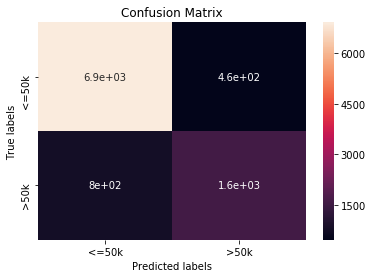

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
labels = [0, 1]
cm = confusion_matrix(y_test, y_test_hat, labels)
print(cm)
ax =  plt.subplot()
sns.heatmap(cm, annot = True, ax = ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['<=50k', '>50k']); 
ax.yaxis.set_ticklabels(['<=50k', '>50k']);

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7375
           1       0.78      0.66      0.72      2388

    accuracy                           0.87      9763
   macro avg       0.84      0.80      0.82      9763
weighted avg       0.87      0.87      0.87      9763



# Model Saving

In [0]:
model.save_model(model_path + 'catboost_model.json', format = 'json')